In [1]:
library(jsonlite)
library(ggplot2)
library(ggtree)
library(aplot)

DATA_DIR <- file.path("Data", "SARS-CoV-2_genome")
OUTPUT_DIR <- "Output"

ggtree v3.0.2  For help: https://yulab-smu.top/treedata-book/

If you use ggtree in published research, please cite the most appropriate paper(s):

1. Guangchuang Yu. Using ggtree to visualize data on tree-like structures. Current Protocols in Bioinformatics, 2020, 69:e96. doi:10.1002/cpbi.96
2. Guangchuang Yu, Tommy Tsan-Yuk Lam, Huachen Zhu, Yi Guan. Two methods for mapping and visualizing associated data on phylogeny using ggtree. Molecular Biology and Evolution 2018, 35(12):3041-3043. doi:10.1093/molbev/msy194
3. Guangchuang Yu, David Smith, Huachen Zhu, Yi Guan, Tommy Tsan-Yuk Lam. ggtree: an R package for visualization and annotation of phylogenetic trees with their covariates and other associated data. Methods in Ecology and Evolution 2017, 8(1):28-36. doi:10.1111/2041-210X.12628





In [2]:
df <- read.csv(file.path(DATA_DIR, "paraFixSites.csv"))

df[which(df$type == "paraFix"), "type"] <- "parallel"

In [3]:
siteLabel <- read.csv(file.path(DATA_DIR, "siteLabel.csv"))

siteLabel$name <- factor(siteLabel$name, unique(siteLabel$name))

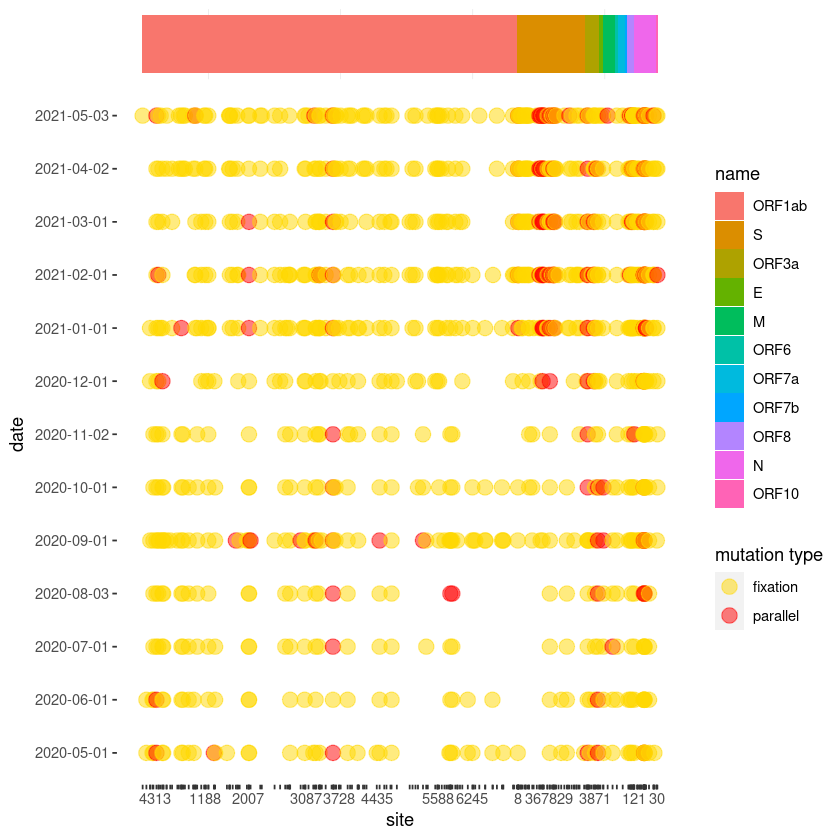

In [4]:
annotation <- ggplot(siteLabel, aes(peptidePos, y=type, fill=name)) +
    geom_tile() + 
    scale_y_discrete(position="right") +
    theme_minimal() + 
    theme(
        axis.text = element_blank(), 
        axis.ticks = element_blank(),
        panel.grid.major = element_line(colour = "white")
    ) +
    xlab(NULL) + ylab(NULL)

p <- ggplot(df, aes(x = site, y = date, color = factor(type))) +
    geom_point(size = 4, alpha = 0.5) +
#     facet_grid( ~ gene, scales = "free", space = "free") +
    scale_x_continuous(breaks = unique(df$site),
                       labels = df$aaPos[which(!duplicated(df$site))],
                       guide = guide_axis(check.overlap = TRUE)) +
    scale_color_manual(
        name = "mutation type",
        values = list(
#             "paraFix" = "red",
            "fixation" = "gold",
            "parallel" = "red"
        )
    ) +
    theme(
        panel.background = element_rect(fill = "white"),
        panel.grid.major.x = element_line(
            colour = "white",
            linetype = 3,
        )
    )
p <- insert_top(p, annotation, height = 0.1)
p

ggsave(filename = file.path(OUTPUT_DIR, "paraFix_date.pdf"), plot = p, width = 30, height = 8)

In [15]:
tree <- read.tree(file.path(DATA_DIR, "B.1.351.treefile"))

lineageInfo <- read.csv(file.path(DATA_DIR, "B.1.351_mutInfo.csv"))
lineageInfo[["date"]] <- as.Date(lineageInfo[["date"]])

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



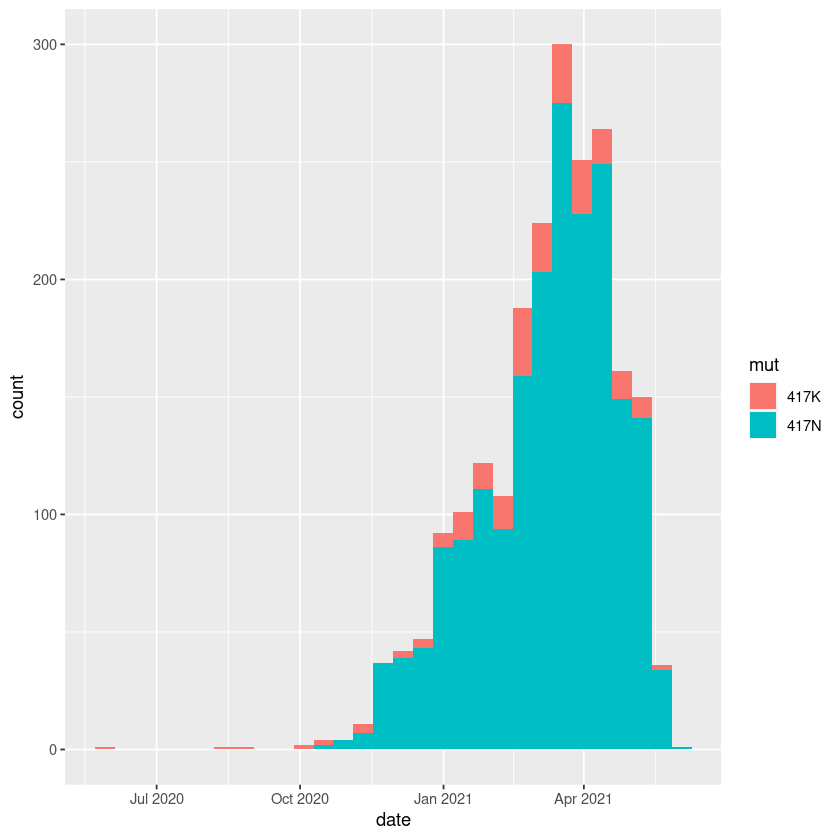

In [17]:
ggplot(lineageInfo, aes(date, fill = mut)) + 
    geom_histogram()

Saving 6.67 x 6.67 in image



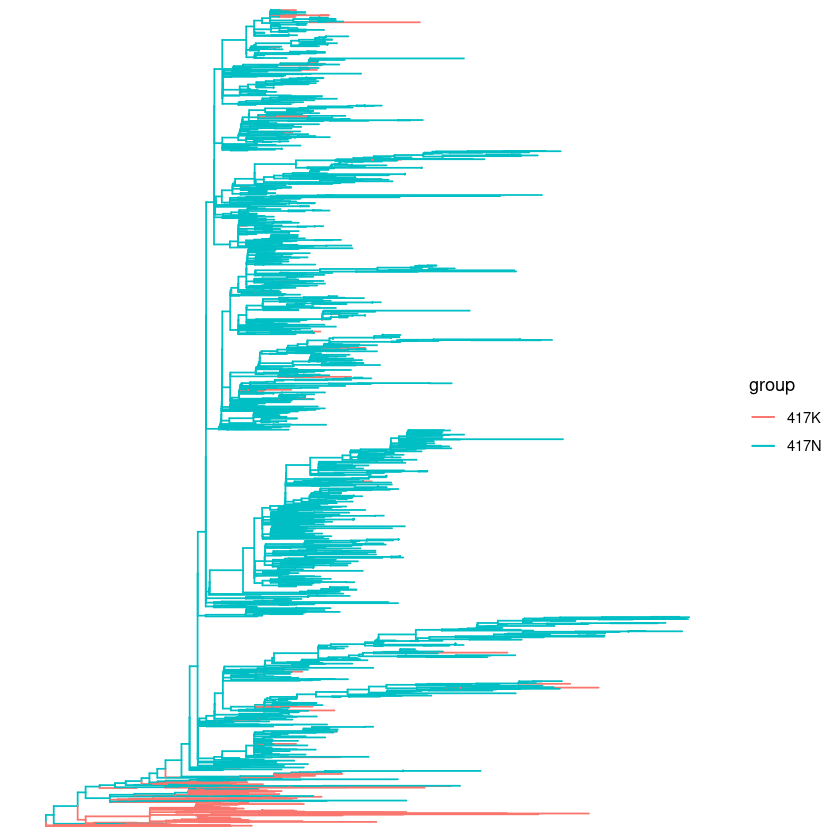

In [18]:
p <- ggtree(groupOTU(tree, split(lineageInfo[["accession"]], lineageInfo[["mut"]])), aes(color = group))
p

ggsave(filename = file.path("Output", "ReverseMut", "K417_revMut_tree.pdf"), plot = p)